# pytorch

In [ ]:
import urllib
url, filename = ("https://media.bunjang.co.kr/product/221232138_{cnt}_1681566135_w{res}.jpg", "shirts.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [ ]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [ ]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

pajama 0.7874180674552917
apron 0.10574471205472946
swimming trunks 0.020261457189917564
bow tie 0.016007767990231514
sweatshirt 0.01297826785594225


# pytorch transfer learning1

In [ ]:
# -- torch._six 에러 생기면 최신 버전으로 업데이트 해주기 --
# !pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html -U

In [ ]:
# # 개와 고양이 데이터 세트 다운로드
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

In [ ]:
# 실습에 필요한 라이브러리 불러오기
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# other
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [ ]:
batch_size=200
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
# 데이터 가져오기
trainset = datasets.CIFAR10(root='dataset/',train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='dataset/',train=False,
                                       download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 79356803.65it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


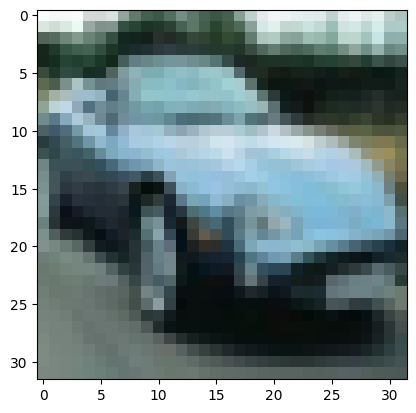

car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

test = iter(trainloader)
images, labels = next(test)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# imshow(torchvision.utils.make_grid(images))
imshow(images[0])
print(classes[labels[0]])

In [ ]:
# 학습 세트에 적용할 데이터 변환을 설정
# 데이터 전처리
train_config = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# 테스트 세트에 적용할 데이터 변환을 설정
test_config = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

In [ ]:
# 모델의 가중치를 더 이상 학습하지 않도록 설정.
# 가중치는 require_grad라는 속성 값을 가지고 있는데 이 값을 False로 설정하면 모델 학습시 이 가중치는 학습하지 않음.
# for param in model.features.parameters():
#     param.require_grad = False

In [ ]:
# 출력층을 1개의 노드를 가진 전결합층으로 교체

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(classes))



## 모델의 연산을 그래픽 카드에서 하도록 설정
print(model.to('cuda'))

In [ ]:
# model 클래스 개수
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# Training
def train(epoch, model, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss/total
    epoch_acc = correct/total*100
    print("Train | Loss:%.4f Acc: %.2f%% (%s/%s)"
        % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

def test(epoch, model, criterion, optimizer):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()*inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = test_loss/total
        epoch_acc = correct/total*100
        print("Test | Loss:%.4f Acc: %.2f%% (%s/%s)"
            % (epoch_loss, epoch_acc, correct, total))
    return epoch_loss, epoch_acc

In [ ]:
import time
start_time = time.time()
best_acc = 0
epoch_length = 100
save_loss = {"train":[],
             "test":[]}
save_acc = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, model, criterion, optimizer)
    save_loss['train'].append(train_loss)
    save_acc['train'].append(train_acc)

    test_loss, test_acc = test(epoch, model, criterion, optimizer)
    save_loss['test'].append(test_loss)
    save_acc['test'].append(test_acc)

    scheduler.step()

    # Save model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

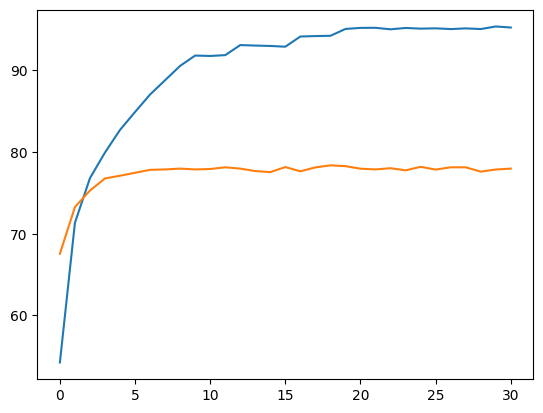

In [ ]:
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

In [5]:

# Define your custom dataset path and image transformations
data_dir = "/content/drive/MyDrive/bungae_images_v3/"
image_size = 224  # Adjust the size according to your requirements

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the custom dataset using the ImageFolder class
image_datasets = {x: datasets.ImageFolder(root=data_dir, transform=data_transforms[x])
                  for x in ["train", "val"]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
               for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes


In [6]:
# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
num_classes = len(class_names)

# Modify the last fully connected layer of the model
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze initial layers and train only the later layers
for param in model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 224MB/s]


In [ ]:
# Train the model
num_epochs = 10  # Adjust the number of epochs as needed

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete!")

# Access the accuracy and loss values from the lists
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accs)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accs)


In [ ]:
# -- squeezenet --

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

In [2]:
# # Define your custom dataset path and image transformations
# data_dir = "/content/drive/MyDrive/bungae_images_v3/"
# image_size = 224  # Adjust the size according to your requirements
# resized_image_size = 128  # Adjust the size for preprocessing

# data_transforms = {
#     "train": transforms.Compose([
#         transforms.Resize(resized_image_size),
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     "val": transforms.Compose([
#         transforms.Resize(resized_image_size),
#         transforms.CenterCrop(image_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# # Load the custom dataset using the ImageFolder class with preprocessed images
# image_datasets = {x: datasets.ImageFolder(root=data_dir, transform=data_transforms[x])
#                   for x in ["train", "val"]}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
#                for x in ["train", "val"]}
# dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
# class_names = image_datasets["train"].classes

# # Rest of the code remains unchanged...


In [12]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

# Define your custom dataset path and image transformations
data_dir = "/content/drive/MyDrive/bungae_images_v3/"
image_size = 224  # Adjust the size according to your requirements

# Preprocess the images and save them in a separate directory
preprocessed_dir = "/content/drive/MyDrive/v3_bungae_preprocessed_images/"
os.makedirs(preprocessed_dir, exist_ok=True)

data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

for phase in ["train", "val"]:
    phase_dir = os.path.join(preprocessed_dir, phase)
    os.makedirs(phase_dir, exist_ok=True)

    for filename in tqdm(os.listdir(os.path.join(data_dir, phase))):
        if filename.startswith('.'):
            continue  # Skip hidden files

        image_path = os.path.join(data_dir, phase, filename)

        try:
            label = int(filename.split("_")[0])
        except ValueError:
            continue  # Skip files with invalid labels

        try:
            image = Image.open(image_path)
            image = data_transforms(image)

            # Save the preprocessed image as numpy array
            preprocessed_image_path = os.path.join(phase_dir, filename.split(".")[0] + ".npy")
            np.save(preprocessed_image_path, image.numpy())

        except OSError:
            continue  # Skip files that cannot be opened as images


100%|██████████| 157/157 [00:35<00:00,  4.46it/s]


In [ ]:
# Load the preprocessed dataset using a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for phase in ["train", "val"]:
            phase_dir = os.path.join(self.data_dir, phase)
            for filename in os.listdir(phase_dir):
                if filename.endswith(".npy"):
                    image_path = os.path.join(phase_dir, filename)
                    label = int(filename.split("_")[0])
                    samples.append((image_path, label))
        return samples

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = np.load(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.samples)

# Load the preprocessed dataset using the CustomDataset class
preprocessed_datasets = {x: CustomDataset(preprocessed_dir, transform=data_transforms[x])
                         for x in ["train", "val"]}
dataloaders = {x: DataLoader(preprocessed_datasets[x], batch_size=64, shuffle=True, num_workers=4)
               for x in ["train", "val"]}
dataset_sizes = {x: len(preprocessed_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes


In [3]:
# Load the pretrained SqueezeNet model
model = models.squeezenet1_1(pretrained=True)
num_classes = len(class_names)

# Modify the classifier of the model
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze initial layers and train only the later layers
for param in model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 75.1MB/s]


In [ ]:
# Train the model
num_epochs = 10  # Adjust the number of epochs as needed

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete!")

# Access the accuracy and loss values from the lists
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accs)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accs)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

# Define your custom dataset path and image transformations
data_dir = "/content/drive/MyDrive/bungae_images_v3/"
image_size = 224  # Adjust the size according to your requirements

# Preprocess the images and save them in a separate directory
preprocessed_dir = "/content/drive/MyDrive/v3_bungae_preprocessed_images/"
os.makedirs(preprocessed_dir, exist_ok=True)

data_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

for phase in ["train", "val"]:
    phase_dir = os.path.join(preprocessed_dir, phase)
    os.makedirs(phase_dir, exist_ok=True)

    for filename in tqdm(os.listdir(os.path.join(data_dir, phase))):
        if filename.startswith('.'):
            continue  # Skip hidden files

        image_path = os.path.join(data_dir, phase, filename)

        try:
            label = int(filename.split("_")[0])
        except ValueError:
            continue  # Skip files with invalid labels

        try:
            image = Image.open(image_path)
            image = data_transforms(image)

            # Save the preprocessed image as numpy array
            preprocessed_image_path = os.path.join(phase_dir, filename.split(".")[0] + ".npy")
            np.save(preprocessed_image_path, image.numpy())

        except OSError:
            continue  # Skip files that cannot be opened as images


In [15]:
# Load the preprocessed dataset using a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for phase in ["train", "val"]:
            phase_dir = os.path.join(self.data_dir, phase)
            for filename in os.listdir(phase_dir):
                if filename.endswith(".npy"):
                    image_path = os.path.join(phase_dir, filename)
                    label = int(filename.split("_")[0])
                    samples.append((image_path, label))
        return samples

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = np.load(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.samples)

# Define the transformations for train and val phases
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Update with your normalization values
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Update with your normalization values
])

# Load the preprocessed dataset using the CustomDataset class
preprocessed_datasets = {
    "train": CustomDataset(preprocessed_dir, transform=train_transform),
    "val": CustomDataset(preprocessed_dir, transform=val_transform)
}

# Debug: Print the number of samples in each phase
for phase in ["train", "val"]:
    print(f"{phase} samples: {len(preprocessed_datasets[phase])}")

dataloaders = {
    "train": DataLoader(preprocessed_datasets["train"], batch_size=64, shuffle=True, num_workers=4),
    "val": DataLoader(preprocessed_datasets["val"], batch_size=64, shuffle=True, num_workers=4)
}

dataset_sizes = {x: len(preprocessed_datasets[x]) for x in ["train", "val"]}
class_names = list(range(num_classes))  # Update class_names to a list of labels


# Modify the classifier of the model
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes

train samples: 0
val samples: 0


ValueError: ignored

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze initial layers and train only the later layers
for param in model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)



In [ ]:
# Train the model
num_epochs = 10  # Adjust the number of epochs as needed

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete!")

# Access the accuracy and loss values from the lists
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accs)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accs)


In [ ]:
# -- mobileNet V3 small --

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm


In [ ]:
# Define your custom dataset path and image transformations
data_dir = "/content/drive/MyDrive/bungae_images_v3/"
image_size = 224  # Adjust the size according to your requirements

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the custom dataset using the ImageFolder class
image_datasets = {x: datasets.ImageFolder(root=data_dir, transform=data_transforms[x])
                  for x in ["train", "val"]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4)
               for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes


In [ ]:
# Load the pretrained MobileNetV3-Small model
model = models.mobilenet_v3_small(pretrained=True)
num_classes = len(class_names)

# Modify the classifier of the model
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze initial layers and train only the later layers
for param in model.features.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# Train the model
num_epochs = 10  # Adjust the number of epochs as needed

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in tqdm(range(num_epochs)):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimization only in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == "train":
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete!")

# Access the accuracy and loss values from the lists
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accs)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accs)
